<a href="https://colab.research.google.com/github/hollymangu/Starbucks-Stock-Price-Prediction-Using-Deep-Learning/blob/main/ML_Coursework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Starbucks Stock Price Prediction Using Deep Learning**
## ML Coursework 2 - CW2_Group4
### Members:


*   Seyda Tatlicioglu (K2451397)
*   Kulanika Gnanaratna (K2443219)
*   Holly Mangu (K2121417)
*   Ansar Ahmad (K2403224)




In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller

In [ ]:
df = pd.read_csv('/content/Starbucks.csv')

In [ ]:
df.head(5), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1800 non-null   int64  
 1   Date        1800 non-null   object 
 2   Open        1800 non-null   float64
 3   Time        1800 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 56.4+ KB


(   Unnamed: 0        Date   Open          Time
 0           0  11/13/2017  56.81  1.510531e+09
 1           1  11/14/2017  56.47  1.510618e+09
 2           2  11/15/2017  56.82  1.510704e+09
 3           3  11/16/2017  56.92  1.510790e+09
 4           4  11/17/2017  57.24  1.510877e+09,
 None)

In [ ]:
# Drop unnamed column which is index column, then Date to proper datatype, then add 'Year','Month', and 'Day' as a seperate column

df.drop('Unnamed: 0', axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day


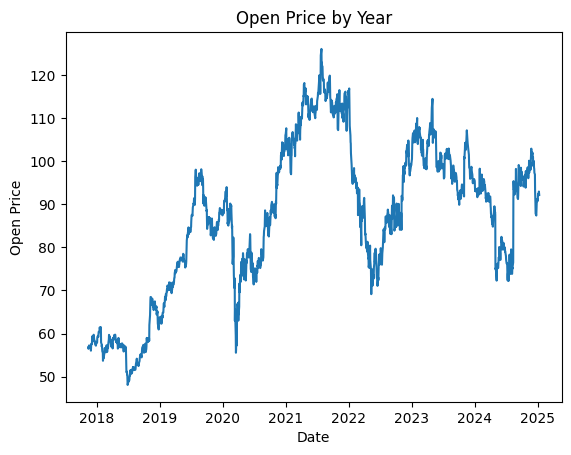

In [ ]:
# Visualise the price by year

plt.plot(df['Date'], df['Open'])
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open Price by Year')
plt.show()

In [ ]:
# Calculating 3-day, 7-day and 30-day moving average and propagate the next valid observation backward to fill the NaN values in

df['MA_3day'] = df['Open'].rolling(window=3).mean().bfill()
df['MA_7day'] = df['Open'].rolling(window=5).mean().bfill()
df['MA_30day'] = df['Open'].rolling(window=30).mean().bfill()


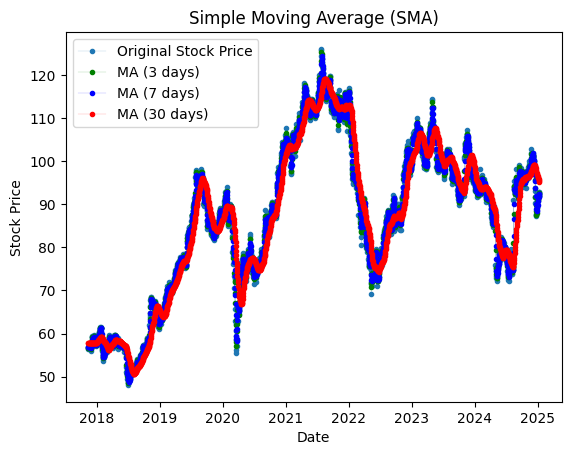

In [ ]:
# Simple Moving Average (SMA)
plt.plot(df['Date'], df['Open'], label='Original Stock Price', marker='.', linewidth = 0.1)
plt.plot(df['Date'], df['MA_3day'], label='MA (3 days)', marker='.', color='green', linewidth = 0.1)
plt.plot(df['Date'], df['MA_7day'], label='MA (7 days)', marker='.', color='blue', linewidth = 0.1)
plt.plot(df['Date'], df['MA_30day'], label='MA (30 days)', marker='.', color='red', linewidth = 0.1)
plt.title("Simple Moving Average (SMA)")
plt.ylabel("Stock Price")
plt.xlabel("Date")
plt.legend()
plt.show()

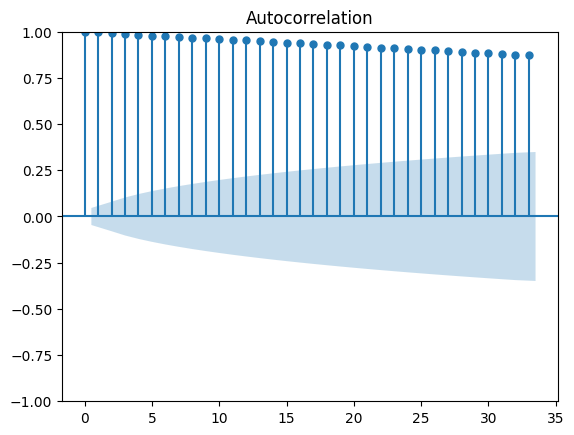

In [ ]:
# Create the autocorrelation graph to see how correlated the price

plot_acf(df['Open'], alpha =0.05)
plt.show()

Strong correlation at all lags: The bars remain close to 1.0 for all lags, meaning past values strongly influence the present.

Slowly decreasing trend: The bars decrease gradually instead of dropping quickly. This indicates long-term dependencies, meaning past prices far back still influence future prices.


In [ ]:
# Creating columns with Lag feautures, uses past price values as input and forward filling for Lagged columns

df['Lagged_Value_3day'] = df['Open'].shift(-3).ffill()
df['Lagged_Value_7day'] = df['Open'].shift(-7).ffill()
df['Lagged_Value_30day'] = df['Open'].shift(-30).ffill()

# Price Return (% change from previous day)
df['Return_1'] = df['Open'].pct_change().bfill()

# Rolling 3-day Volatility (Standard Deviation)
df['Volatility_3'] = df['Open'].rolling(window=3).std().bfill()

# Raw price difference
df['Price_Change'] = df['Open'].diff().bfill()

# Drop NaN values
df.dropna(inplace=True)

In [ ]:
# Calculate the split indices
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))

# creates the training dataset by selecting the first 80% of the data
train_data = df[:train_size]
# creates the validation dataset by selecting the next 10% of the data after the training data.
val_data = df[train_size:train_size + val_size]
# creates the test dataset by selecting the remaining data after the training and validation sets.
test_data = df[train_size + val_size:]

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 1440, Validation: 180, Test: 180


In [ ]:
# Feature Scaling

scaler = StandardScaler()
features = ['MA_3day', 'MA_7day', 'MA_30day', 'Lagged_Value_3day', 'Lagged_Value_7day', 'Lagged_Value_30day']
target = 'Open'  # forecast for 'Open' price

# Fit the scaler on training data and transform all sets
scaler.fit(train_data[features + [target]])

train_scaled = scaler.transform(train_data[features + [target]])
val_scaled = scaler.transform(val_data[features + [target]])
test_scaled = scaler.transform(test_data[features + [target]])

# Convert back to DataFrame
train_scaled = pd.DataFrame(train_scaled, columns=features + [target], index=train_data.index)
val_scaled = pd.DataFrame(val_scaled, columns=features + [target], index=val_data.index)
test_scaled = pd.DataFrame(test_scaled, columns=features + [target], index=test_data.index)


# **MLP**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, Add
from tensorflow.keras import regularizers

In [ ]:
# Features (X) and target (y) for MLP model
features_mlp = ['MA_7day', 'MA_30day', 'Lagged_Value_3day', 'Lagged_Value_7day', 'Lagged_Value_30day', 'Return_1', 'Volatility_3','Price_Change', 'MA_3day' ]
target = 'Open'

X_train_mlp = train_data[features]
y_train_mlp = train_data[[target]]

X_val_mlp = val_data[features]
y_val_mlp = val_data[[target]]

X_test_mlp = test_data[features]
y_test_mlp = test_data[[target]]

In [ ]:
# Feature Scaling
scaler_X = StandardScaler()
features_mlp = ['MA_7day', 'MA_30day', 'Lagged_Value_3day', 'Lagged_Value_7day', 'Lagged_Value_30day', 'Return_1', 'Volatility_3','Price_Change', 'MA_3day' ]

# Fit on training data only
scaler_X.fit(train_data[features_mlp])

# Transform all sets
train_scaled_X = scaler_X.transform(train_data[features_mlp])
val_scaled_X = scaler_X.transform(val_data[features_mlp])
test_scaled_X = scaler_X.transform(test_data[features_mlp])

scaler_y = StandardScaler()
target = 'Open'

# Fit only on training target values
scaler_y.fit(train_data[[target]])

# Transform target values separately
train_scaled_y = scaler_y.transform(train_data[[target]])
val_scaled_y = scaler_y.transform(val_data[[target]])
test_scaled_y = scaler_y.transform(test_data[[target]])

In [ ]:
train_scaled = pd.DataFrame(train_scaled_X, columns=features_mlp, index=train_data.index)
train_scaled[target] = train_scaled_y

val_scaled = pd.DataFrame(val_scaled_X, columns=features_mlp, index=val_data.index)
val_scaled[target] = val_scaled_y

test_scaled = pd.DataFrame(test_scaled_X, columns=features_mlp, index=test_data.index)
test_scaled[target] = test_scaled_y

In [ ]:
def residual_block(x, units, dropout_rate=0.2, l2_lambda=0.001):
    shortcut = x
    x = Dense(units, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(units, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])  # Residual connection
    x = ReLU()(x)
    return x

In [ ]:
# Define input
input_dim = train_scaled_X.shape[1]
inputs = Input(shape=(input_dim,))

# Initial Dense layer
x = Dense(128, kernel_regularizer=regularizers.l2(0.001))(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

# Residual Blocks
x = residual_block(x, 128)
x = residual_block(x, 128)

# Final projection layer
output = Dense(1)(x)

# Build and compile
mlp_model = Model(inputs=inputs, outputs=output)

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Early Stopping and Reducing Lr
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)

# Train the model
history_mlp = mlp_model.fit(
    train_scaled_X, train_scaled_y,
    validation_data=(val_scaled_X, val_scaled_y),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 2.4696 - mae: 1.0179 - val_loss: 0.8290 - val_mae: 0.4884 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0101 - mae: 0.5122 - val_loss: 0.6582 - val_mae: 0.3135 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8038 - mae: 0.4134 - val_loss: 0.5965 - val_mae: 0.2325 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7701 - mae: 0.3851 - val_loss: 0.5713 - val_mae: 0.1607 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7482 - mae: 0.3626 - val_loss: 0.5643 - val_mae: 0.1566 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7007 - mae: 0.3370 - val_loss: 0.5528 - val_mae: 0.1306 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6866 - mae: 0.3149 - val_loss: 0.5373 - val_mae: 0.1215 - learning_rate: 0.0010
Epoch 8/100


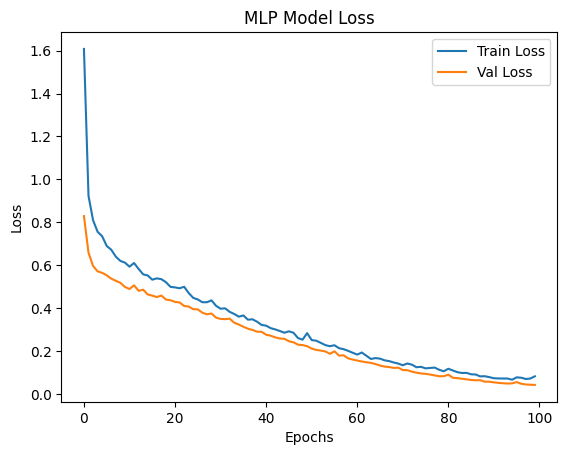

In [ ]:
# Plot loss curves
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Val Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


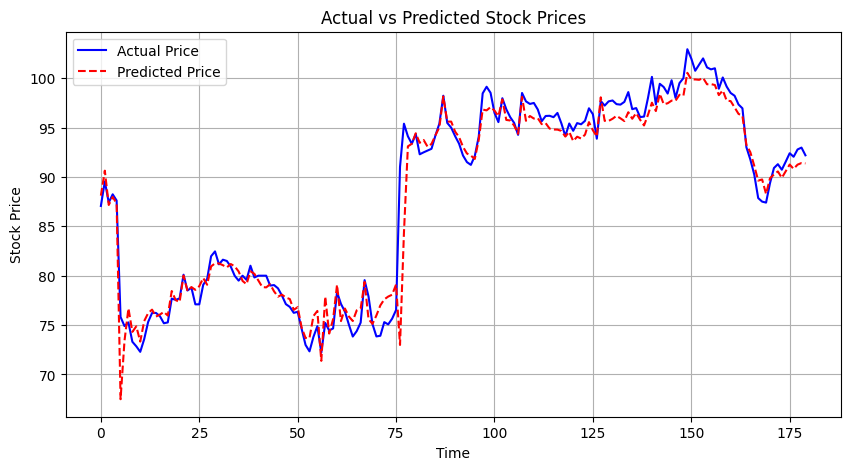

In [ ]:
# Predict and inverse scale
y_pred_scaled = mlp_model.predict(test_scaled_X)
y_pred_mlp = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(test_scaled_y)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_actual, label="Actual Price", color='blue')
plt.plot(y_pred_mlp, label="Predicted Price", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Metrics
mae_mlp = mean_absolute_error(y_actual, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_actual, y_pred_mlp))
r2_mlp = r2_score(y_actual, y_pred_mlp)

# Print them nicely
print(f"MAE  (Mean Absolute Error): {mae_mlp:.3f}")
print(f"RMSE (Root Mean Squared Error): {rmse_mlp:.3f}")
print(f"R²   (R-squared Score): {r2_mlp:.4f}")

MAE  (Mean Absolute Error): 1.202
RMSE (Root Mean Squared Error): 2.082
R²   (R-squared Score): 0.9532


# **Vanilla RNN**

RNN network has a consistant layer that loops over sequential data.
maintains a hidden state that carries information across time steps (suitable for time-series forecasting)

Processes data sequentially.

Maintains a hidden state (memory).

Uses SimpleRNN in Keras (basic RNN cell).

Works well for short-term dependencies (but struggles with long sequences).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Create Time-Series Sequences
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps][features].values)  # Use all feature columns
        y.append(data.iloc[i+time_steps][target])  # Predicting 'Open'
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_scaled, time_steps)
X_val, y_val = create_sequences(val_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

In [ ]:
# Build RNN Model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(time_steps, len(features))),
    SimpleRNN(50, activation='relu'),
    Dense(1)  # Output Layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile Model
rnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train Model
history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0436 - val_loss: 0.0069
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0016 - val_loss: 9.6839e-04
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0012 - val_loss: 7.5590e-04
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0033 - val_loss: 7.2541e-04
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

In [ ]:
# Evaluate Model
y_pred = rnn_model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


In [ ]:
# Evaluate on test set for Vanilla RNN
test_loss_rnn = rnn_model.evaluate(X_test, y_test, batch_size=16, verbose=1)
print(f"Test Loss (MSE): {test_loss_rnn:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Test Loss (MSE): 0.0015


In [ ]:
# Reverse Scaling for Comparison
y_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), len(features))), y_pred.reshape(-1, 1)), axis=1))[:, -1]
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), len(features))), y_test.reshape(-1, 1)), axis=1))[:, -1]

In [ ]:
# Compute Metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

print(f"Test MAE: {mae:.4f}, Test MSE: {mse:.4f}, R² Score: {r2:.4f}")

Test MAE: 0.4749, Test MSE: 0.5750, R² Score: 0.9932


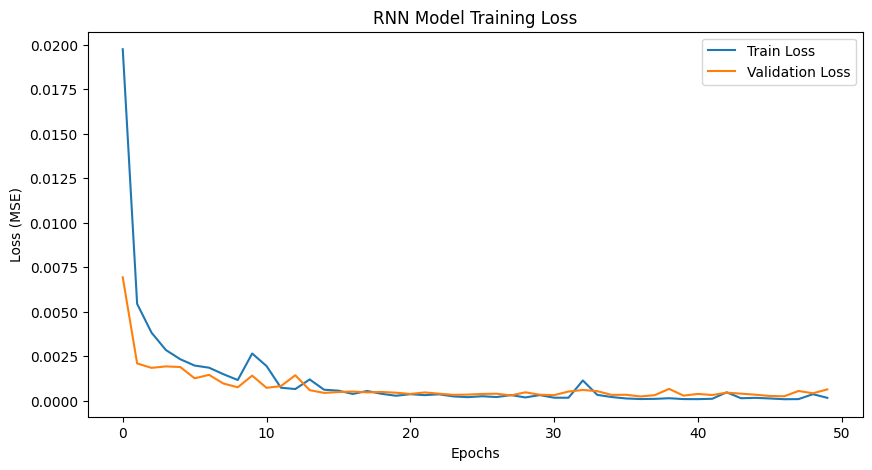

In [ ]:
# Plot Loss Curve for Vanilla RNN
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('RNN Model Training Loss')
plt.legend()
plt.show()

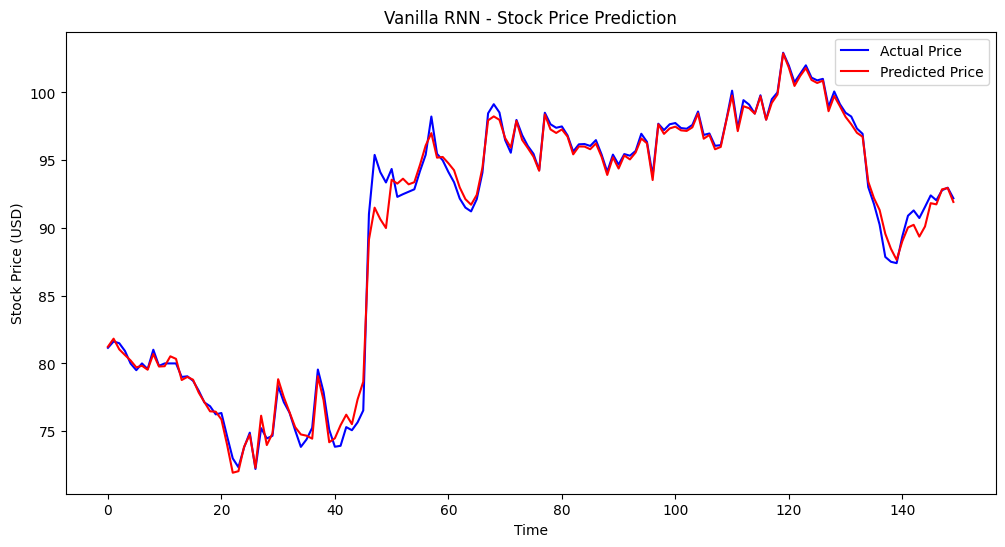

In [ ]:
# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='red')
plt.title("Vanilla RNN - Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.legend()
plt.show()

## LSTM Model

In [ ]:
 # Create Time-Series Sequences
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i+time_steps][features].values)  # Use all feature columns
        y.append(data.iloc[i+time_steps][target])  # Predicting 'Open'
    return np.array(X), np.array(y)

time_steps = 30
X_train, y_train = create_sequences(train_scaled, time_steps)
X_val, y_val = create_sequences(val_scaled, time_steps)
X_test, y_test = create_sequences(test_scaled, time_steps)

In [ ]:
# Define LSTM model
model_lstm = Sequential([
    Input(shape=(7, len(features))),  # Explicit input layer
    LSTM(50, activation='relu', return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Dropout for regularization
    LSTM(50, activation='relu', return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25, activation='relu'),  # Fully connected layer
    Dense(1)  # Output layer (predicting Open price)
    ])


# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Stop after 5 epochs with no improvement
    restore_best_weights=True )


# Train the model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.2734 - val_loss: 0.0258
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0512 - val_loss: 0.0127
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0367 - val_loss: 0.0106
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0333 - val_loss: 0.0125
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0249 - val_loss: 0.0069
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0224 - val_loss: 0.0112
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0243 - val_loss: 0.0078
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0213 - val_loss: 0.0075
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0159 - val_loss: 0.0090
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0168 - val_loss: 0.0077


In [ ]:
# Evaluate on test set

test_loss_lstm = model_lstm.evaluate(X_test, y_test, batch_size=16, verbose=1)
print(f"Test Loss: {test_loss_lstm:.4f}")



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0212
Test Loss: 0.0180


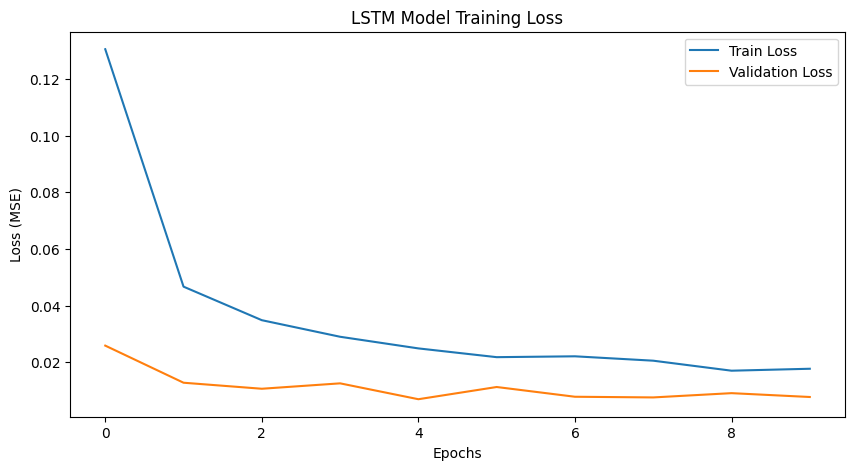

In [ ]:
# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Model Training Loss')
plt.legend()
plt.show()



In [ ]:

# Ensure X_test is a tensor with the correct dtype
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Make predictions
y_pred_lstm = model_lstm.predict(X_test)

# Ensure y_pred_lstm is properly shaped
y_pred_lstm = y_pred_lstm.reshape(-1, 1)

# Convert predictions back to original scale
dummy_features = np.zeros((len(y_pred_lstm), len(features)))
y_pred_rescaled_lstm = scaler.inverse_transform(np.concatenate((dummy_features, y_pred_lstm), axis=1))[:, -1]

# Convert y_test back to original scale
y_test = np.array(y_test).reshape(-1, 1)
dummy_features_test = np.zeros((len(y_test), len(features)))
y_test_rescaled = scaler.inverse_transform(np.concatenate((dummy_features_test, y_test), axis=1))[:, -1]



1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


In [ ]:
# Compute Metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled_lstm)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled_lstm)
r2 = r2_score(y_test_rescaled, y_pred_rescaled_lstm)

# Print Metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 6.7272
Mean Absolute Error (MAE): 1.8409
R² Score: 0.9206


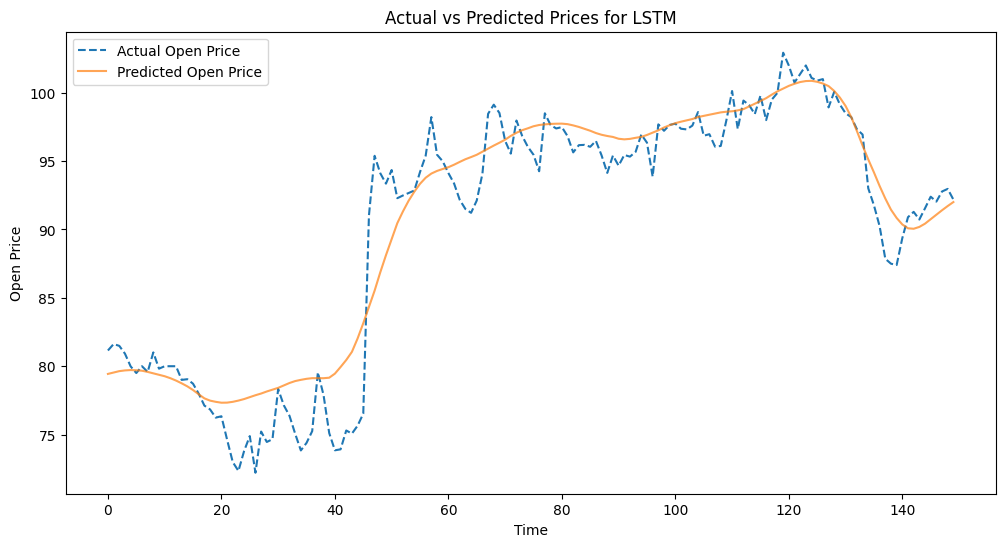

In [ ]:
# Plot Actual Price and Predicted Price
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Open Price", linestyle='dashed')
plt.plot(y_pred_rescaled_lstm, label="Predicted Open Price", alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.title('Actual vs Predicted Prices for LSTM')
plt.legend()
plt.show()


# CNN Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load dataset
df = pd.read_csv('/content/Starbucks.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Open']]

In [ ]:
# Normalize data
scaler = MinMaxScaler()
df['Open'] = scaler.fit_transform(df[['Open']])

In [ ]:
# Create time series dataset
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train_data, val_data, test_data = df[:train_size], df[train_size:train_size+val_size], df[train_size+val_size:]

X_train, y_train = create_sequences(train_data.values, seq_length)
X_val, y_val = create_sequences(val_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)

In [ ]:


# Define CNN model
def build_cnn_model():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train and evaluate existing CNN model
cnn_model = build_cnn_model()
cnn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0229 - val_loss: 0.0022
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0012
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 7.4450e-04
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 8.0376e-04
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 6.9779e-04
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038 - val_loss: 9.0192e-04
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 7.0206e-04
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031

In [ ]:
# Evaluate model
y_pred = cnn_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = mean_absolute_error(y_test_inv, y_pred)
mse = mean_squared_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)




# Print results
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE: 2.0493, MSE: 7.2751, R2: 0.9141


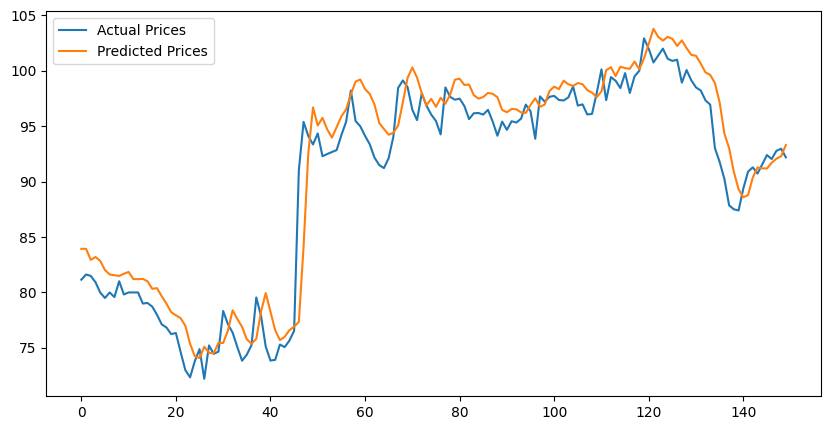

In [ ]:

# Plot results
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.legend()
plt.show()

In [ ]:
# Save model after training
mlp_model.save("residual_mlp_model.h5")
rnn_model.save("vanilla_rnn_model.h5")
model_lstm.save("lstm_model.h5")
cnn_model.save("cnn_model.h5")

# **Results**

In [ ]:
# Store results in a dictionary
model_results = {
    "MLP": {"MSE": 1.613, "MAE": 1.264 , "R²": 0.9719 },
    "Vanilla RNN": {"MSE": 0.8227, "MAE": 0.5830, "R²": 0.9903},
    "LSTM": {"MSE": 3.6174, "MAE": 1.4287 , "R²": 0.9573},
    "CNN": {"MSE": 10.8170, "MAE": 2.4946 , "R²": 0.8723 }
}


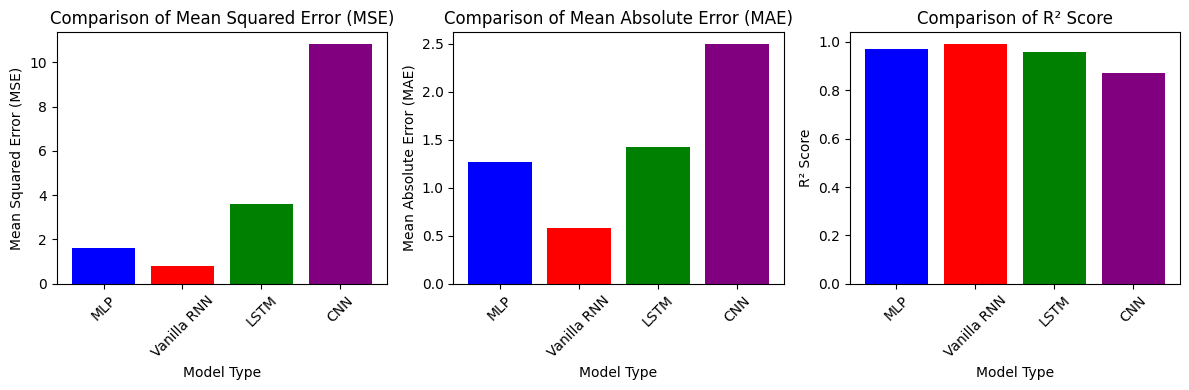

In [ ]:
models = list(model_results.keys())
mse_scores = [model_results[m]["MSE"] for m in models]
mae_scores = [model_results[m]["MAE"] for m in models]
r2_scores = [model_results[m]["R²"] for m in models]

metrics = [("Mean Squared Error (MSE)", mse_scores),
           ("Mean Absolute Error (MAE)", mae_scores),
           ("R² Score", r2_scores)]

plt.figure(figsize=(12, 4))

for i, (title, scores) in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.bar(models, scores, color=['blue', 'red', 'green', 'purple'])
    plt.xlabel("Model Type")
    plt.ylabel(title)
    plt.title(f"Comparison of {title}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# References

**References for Moving Average**

- A. R. Sharma and A. Garg, "Prediction of Trends in Stock Market
using Moving Averages and Machine Learning," International Journal of Advanced Trends in Computer Science and Engineering, vol. 10, no. 3, pp. 2030-2036, May 2021. Available: https://www.researchgate.net/publication/351487736.



- N. M. Supri, S. F. A. Shah, A. H. M. Saifullah, M. R. M. Yusoff, and A. A. A. Hamid, "A Hybrid Stock Price Prediction Model Based on PRE and Deep Neural Network," International Journal of Advanced Computer Science and Applications (IJACSA), vol. 13, no. 4, pp. 176-182, 2022. Available: https://www.researchgate.net/publication/360151928.

- A. N. Kis, “Understanding autocorrelation and partial autocorrelation functions (ACF and PACF),” Medium, Sep. 5, 2020. [Online]. Available: https://medium.com/@kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5.


**MLP References**
- J. Fan and Y. Shen, “StockMixer: A Simple Yet Strong MLP-Based Architecture for Stock Price Forecasting,” Proceedings of the AAAI Conference on Artificial Intelligence, vol. 38, no. 8, pp. 8389–8397, Mar. 2024, doi: https://doi.org/10.1609/aaai.v38i8.28681.


- A. Lazcano, M. A. Jaramillo-Morán, and J. E. Sandubete, “Back to Basics: The Power of the Multilayer Perceptron in Financial Time Series Forecasting,” Mathematics, vol. 12, no. 12, p. 1920, Jun. 2024, doi: https://doi.org/10.3390/math12121920.


**RNN References**

- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

- https://medium.com/analytics-vidhya/recurrent-neural-networks-rnns-and-time-series-forecasting-d9ea933426b3

- [3] Rumelhart, D., Hinton, G. & Williams, R. Learning representations by back-propagating errors(1986). https://doi.org/10.1038/323533a0

**LSTM References**

- M. Roondiwala, H. Patel, and S. Varma, "Predicting Stock Prices Using LSTM," International Journal of Science and Research (IJSR), vol. 6, no. 4, pp. 1754-1756, 2017. ISSN: 2319-7064. Available: https://www.researchgate.net/publication/327967988.

- S. Debroy, "Stocks forecast using LSTM and AzureML," Medium, Aug. 31, 2019. Available: https://medium.com/@shuv.sdr/stocks-forecast-using-lstm-and-azureml-e90f1c19b80a.

- GeeksforGeeks, "Training and validation loss in deep learning," GeeksforGeeks, Available: https://www.geeksforgeeks.org/training-and-validation-loss-in-deep-learning/. [Accessed: March 20, 2025].